In [1]:
import sys
import shap
import matplotlib.pyplot as plt

from itertools import compress
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from audioop import cross
from tabnanny import verbose
from sklearn.model_selection import cross_validate
from import_library import *
from model_stack import model_list
from func import loaders
from xgboost import plot_importance

sys.path.append('..')

-VERSION-PLACEHOLDER- is an invalid version and will not be supported in a future release


In [31]:
print("CPU count: {}".format(multiprocessing.cpu_count()))
data_type ='mean_var_cv'               #mean, var, mix,mix_first,mean_var_cv
data_value_type = "FC_mvc"      #ALFF, FC,ALFF_mvc,FC_mvc
FirstMix_value_type = "MOCA" #AD8,MOCA
grid = True
kfold = KFold(n_splits=5)
cross_v = True

CPU count: 24


In [32]:
# Data from R-boruta feature selection

if data_value_type == 'ALFF_mix' or data_value_type == 'FC_mix':
    feature_selection_df_savepath='./feature_selection/feature_selection_result_R_boruta(mix)/'
elif data_value_type == 'FC_mvc':
    feature_selection_df_savepath = './feature_selection/feature_selection_result_R_boruta(m+v+c)/'
elif data_value_type == 'ALFF_mvc':
    feature_selection_df_savepath = './feature_selection/feature_selection_result_R_boruta(m+v+c)/'
else:
    feature_selection_df_savepath = './feature_selection/feature_selection_result_R_boruta/'

# Dataloader
clinical_data = pd.read_csv('./data/clinical data/clinical_data_2.csv')[['subj', 'AD8主觀認知障礙[0-1,>=2]', 'MOCA客觀認知測驗分數[<=23,>=24]']]
raw_data_path = './For_Regression_dataset/'
next_path = [i for i in os.listdir('./For_Regression_dataset/') if 'MOCA'in i or 'AD8' in i]

# feature selection process
rank_threshold = 'R-Boruta-Results'

def feature_filter(patient_value, load_path = None, outcome_name = None, data_type_ = 'mean', data_value_type = None):
    feature_rank_df = pd.read_csv(load_path, index_col = False).rename(columns={'Unnamed: 0': 'feature_name'})
    
    feature_rank_df = feature_rank_df[['feature_name', 'decision']]
    
    if rank_threshold == 'R-Boruta-Results':
        feature_rank_df = feature_rank_df[feature_rank_df['decision']!='Rejected']
    else:
        feature_rank_df = feature_rank_df.head(rank_threshold)

    patient_value = patient_value[feature_rank_df['feature_name'].tolist()]

    return feature_rank_df['feature_name'].tolist(), patient_value

def loader_(data_path = None ,mat_dtype='FCM_mean', outcome_name = None):
    outcome_name_type = ("AD8" if "AD8" in outcome_name else "MOCA")

    if data_type =='mix':
        if data_value_type =='FC': 
            
            # MOCA客觀認知測驗分數[<=23,>=24]_mean_44850_FC.csv
            FC_xy_location = pd.read_csv('FC_xy_feature_location.csv')

            pd_tb_1 = pd.read_csv(os.path.join(data_path[0], '{}_mean_{}_{}.csv'.format(outcome_name, 44850, data_value_type))) 
            pd_tb_2 = pd.read_csv(os.path.join(data_path[0], '{}_var_{}_{}.csv'.format(outcome_name, 44850, data_value_type)))

            pd_patient_index_1, pd_patient_index_2 = pd_tb_1[pd_tb_1.columns[0]]+'_m', pd_tb_2[pd_tb_2.columns[0]]+'_v'
            pd_patient_value_1, pd_patient_value_2 = pd_tb_1[pd_tb_1.columns[1::]], pd_tb_2[pd_tb_2.columns[1::]]

            fd_csv_name = ("R-Boruta-{}-{}_{}_feature-selection_result.csv".format(data_value_type, outcome_name_type, 'mean'))
            col_1, pd_patient_value_1 = feature_filter(pd_patient_value_1, load_path = os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name, data_type_ = 'mean', )
                
            fd_csv_name = ("R-Boruta-{}-{}_{}_feature-selection_result.csv".format(data_value_type, outcome_name_type, 'var'))
            col_2, pd_patient_value_2 = feature_filter(pd_patient_value_2, load_path = os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name, data_type_ = 'var', )

            print(pd_patient_value_1.shape, pd_patient_value_2.shape)
            print()
            
            for i in range(0,len(col_1)):
                FC_number = col_1[i][8:]
                num = int(FC_number)
                col_1[i]=  col_1[i]+'  '+FC_xy_location.values[num,1]

            for i in range(0,len(col_2)):
                FC_number = col_2[i][7:]
                num = int(FC_number)
                col_2[i]=  col_2[i]+'  '+FC_xy_location.values[num,1]
                
            pd_patient_value_mix = pd.DataFrame(np.concatenate((pd_patient_value_1, pd_patient_value_2), axis=1), columns=col_1+col_2)
            
            return col_1+col_2,pd_patient_value_mix,pd_patient_value_mix.values

        else:
            
            pd_tb_1, pd_tb_2 = pd.read_csv(os.path.join(data_path[0], 'mean_mdALFF.csv')), pd.read_csv(os.path.join(data_path[0], 'var_mdALFF.csv'))
            pd_patient_index_1, pd_patient_index_2 = pd_tb_1[pd_tb_1.columns[0]]+'_m', pd_tb_2[pd_tb_2.columns[0]]+'_v'
            pd_patient_value_1, pd_patient_value_2 = pd_tb_1[pd_tb_1.columns[1::]], pd_tb_2[pd_tb_2.columns[1::]]

            fd_csv_name = ("R-Boruta-{}-{}_{}_feature-selection_result.csv".format(data_value_type, outcome_name_type, 'mean'))
            col_1, pd_patient_value_1 = feature_filter(pd_patient_value_1, load_path = os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name, data_type_ = 'mean', )
            
            for i in range(0,len(col_1)-1):
                col_1[i] = col_1[i] + '_mean'
                
            fd_csv_name = ("R-Boruta-{}-{}_{}_feature-selection_result.csv".format(data_value_type, outcome_name_type, 'var'))
            col_2, pd_patient_value_2 = feature_filter(pd_patient_value_2, load_path = os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name, data_type_ = 'var', )
           
            for i in range(0,len(col_2)-1):
                col_2[i] = col_2[i] + '_var'
            
            print(pd_patient_value_1.shape, pd_patient_value_2.shape)
            print()

            pd_patient_value_mix = pd.DataFrame(np.concatenate((pd_patient_value_1, pd_patient_value_2), axis=1), columns=col_1+col_2)          
            
            return col_1+col_2,pd_patient_value_mix,pd_patient_value_mix.values

    elif data_type == 'mix_first':
            if data_value_type == 'ALFF':
                overall_feature_df = 'ALFF_mix(check).csv'
                
                if FirstMix_value_type == "AD8":

                    pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))

                    pd_patient_index = pd_tb[pd_tb.columns[0]]
                    pd_patient_value = pd_tb[pd_tb.columns[1::]]

                    fd_csv_name = ("R-Boruta-ALFF_mix-AD8_feature-selection-result.csv")
                    pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)
                    
                    if data_type == 'mean':
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                    else:
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                            
                    new_pd_patient_ALFF = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

                    return pd_patient_index, new_pd_patient_ALFF,pd_patient_value.values

                else:
                    pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))

                    pd_patient_index = pd_tb[pd_tb.columns[0]]
                    pd_patient_value = pd_tb[pd_tb.columns[1::]]

                    fd_csv_name = ("R-Boruta-ALFF_mix-MOCA_feature-selection-result.csv")
                    pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)
                    
                    if data_type == 'mean':
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                    else:
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                            
                    new_pd_patient_ALFF = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

                    return pd_patient_index, new_pd_patient_ALFF,pd_patient_value.values
            else:
                if FirstMix_value_type == "AD8":

                    overall_feature_df = 'FC_AD8_Firstmix(new).csv'
                    pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))

                    pd_patient_index = pd_tb[pd_tb.columns[0]]
                    pd_patient_value = pd_tb[pd_tb.columns[1::]]
                
                    fd_csv_name = ("R-Boruta-FC_mix-AD8_feature-selection-result.csv")
                    pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)
                    
                    if data_type == 'mean':
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                    else:
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                            
                    new_pd_patient_ALFF = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

                    return pd_patient_index, new_pd_patient_ALFF,pd_patient_value.values

                else:
                    overall_feature_df = 'FC_MOCA_Firstmix(new).csv'
                    pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))

                    pd_patient_index = pd_tb[pd_tb.columns[0]]
                    pd_patient_value = pd_tb[pd_tb.columns[1::]]

                    fd_csv_name = ("R-Boruta-FC_mix-MOCA_feature-selection-result.csv")
                    pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)
                    
                    if data_type == 'mean':
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                    else:
                        for i in range(0,len(pd_patient_index)):
                            pd_patient_index[i] = pd_patient_index[i] 
                            
                    new_pd_patient_ALFF = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

                    return pd_patient_index, new_pd_patient_ALFF,pd_patient_value.values
    elif data_type == 'mean_var_cv':
        if data_value_type == 'ALFF_mvc':
            overall_feature_df = 'ALFF(mean+var+cv)dataset.csv'
            pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))
            pd_patient_index = pd_tb[pd_tb.columns[0]]
            pd_patient_value = pd_tb[pd_tb.columns[1::]]

            fd_csv_name = ("R-Boruta-{}-{}_feature-selection-result.csv".format(data_value_type,outcome_name_type))
            pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)

            new_pd_patient_ALFF = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)
            
            for i in range(0,len(pd_patient_index)):
                list_index = list(pd_patient_index[i])
                list_index.pop(0)
                pd_patient_index[i] = ''.join(list_index)
            
            return pd_patient_index,new_pd_patient_ALFF,pd_patient_value.values
        else:
                overall_feature_df = 'FC(mean+var+cv)dataset.csv'
                pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))
                pd_patient_index = pd_tb[pd_tb.columns[0]]
                pd_patient_value = pd_tb[pd_tb.columns[1::]]

                fd_csv_name = ("R-Boruta-{}-{}_feature-selection-result.csv".format(data_value_type,outcome_name_type))
                pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)

                new_pd_patient_ALFF = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

                return pd_patient_index,new_pd_patient_ALFF,pd_patient_value.values            
    else:
        if data_value_type =='FC': 
            # AD8主觀認知障礙[0-1,>=2]_var_44850_FC.csv
            overall_feature_df = '{}_{}_{}_{}.csv'.format(outcome_name, data_type, 44850, data_value_type)
            pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))

            pd_patient_index = pd_tb[pd_tb.columns[0]]
            pd_patient_value = pd_tb[pd_tb.columns[1::]]

            fd_csv_name = ("R-Boruta-{}-{}_{}_feature-selection_result.csv".format(data_value_type, outcome_name_type, data_type))
            pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)
            FC_xy_location = pd.read_csv('FC_xy_feature_location.csv')

            if data_type == 'var':
                for i in range(0,len(pd_patient_index)):
                    FC_number = pd_patient_index[i][7:]
                    num = int(FC_number)
                    pd_patient_index[i]=  pd_patient_index[i]+'  '+FC_xy_location.values[num,1]
                
                new_pd_patient_FC = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

                return pd_patient_index, new_pd_patient_FC,pd_patient_value.values

            else:
                for i in range(0,len(pd_patient_index)):
                    FC_number = pd_patient_index[i][8:]
                    num = int(FC_number)
                    pd_patient_index[i]=  pd_patient_index[i]+'  '+FC_xy_location.values[num,1]
                
                new_pd_patient_FC = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

                return pd_patient_index, new_pd_patient_FC,pd_patient_value.values

        else:
            overall_feature_df = '{}_mdALFF.csv'.format(data_type)

            pd_tb = pd.read_csv(os.path.join(data_path[0], overall_feature_df))
            pd_patient_index = pd_tb[pd_tb.columns[0]]
            pd_patient_value = pd_tb[pd_tb.columns[1::]]

            fd_csv_name = ("R-Boruta-{}-{}_{}_feature-selection_result.csv".format(data_value_type, outcome_name_type, data_type))
            pd_patient_index, pd_patient_value = feature_filter(pd_patient_value, load_path=os.path.join(feature_selection_df_savepath, fd_csv_name), outcome_name = outcome_name_type)
            
            if data_type == 'mean':
                for i in range(0,len(pd_patient_index)):
                    pd_patient_index[i] = pd_patient_index[i] + '_mean'

            else:
                for i in range(0,len(pd_patient_index)):
                    pd_patient_index[i] = pd_patient_index[i] + '_var'
                    
            new_pd_patient_ALFF = pd.DataFrame(pd_patient_value.values,columns=pd_patient_index)

            return pd_patient_index, new_pd_patient_ALFF,pd_patient_value.values

# AD8

In [27]:
#AD8
result_dict={'outcome':[], 'model':[], 'Reg:mae':[], 'Reg:mse':[],  'Reg:mape':[] }
grid_stack, scores_stack = [], []
outcome_name = 'AD8主觀認知障礙[0-1,>=2]'

model_XGB = XGBRegressor()
model_LGBM = LGBMRegressor()
model_MLPR  = MLPRegressor()

# AD8 & MOCA
label_ = clinical_data[outcome_name]                    
label_ = label_+1

index,patient_data,patient_value = loader_(data_path = [raw_data_path, next_path], outcome_name = outcome_name)

print(index)
print("Overall: ",patient_value.shape)
print("Feature Number: {}".format(patient_value.shape[1]))

# if data_value_type =='FC':
#     print("FC Outcome: {}[{}] - cut rank point: {} - GridSearch: {}".format(outcome_name, data_type, rank_threshold, grid))
# else:
#     print("ALFF Outcome: {}[{}] - cut rank point: {} - GridSearch: {}".format(outcome_name, data_type, rank_threshold, grid))

print()
print("-------Start Training model -------")
print()

if cross_v==True:

    model_XGB = model_XGB.fit(patient_value, np.array(label_))
    overall_pred =  model_XGB.predict(patient_value)
    
    model_LGBM = model_LGBM.fit(patient_value, np.array(label_))
    overall_pred =  model_LGBM.predict(patient_value)

    model_MLPR = model_MLPR.fit(patient_value, np.array(label_))
    overall_pred =  model_MLPR.predict(patient_value)

print('------------------Done------------------')

['13_SomatomotorDorsal_CV', '164_Visual_var', '288_FrontoParietal_mean', '109_DefaultMode_CV', '75_Auditory_var', '265_Visual_CV', '288_FrontoParietal_CV', '65_CinguloOpercular_CV', '211_VentralAttention_mean', '65_CinguloOpercular_mean', '253_SomatomotorDorsal_var', '159_Visual_var', '292_Salience_CV', '277_DefaultMode_mean', '261_CinguloOpercular_CV', '194_FrontoParietal_mean', '171_Visual_mean', '277_DefaultMode_CV']
Overall:  (84, 18)
Feature Number: 18

-------Start Training model -------

------------------Done------------------


# ALFF cv data columns only

In [28]:
# cv data only

new_index = []

for i in range(0,len(patient_data.columns)):
    list_patient = list(patient_data.columns[i])
    list_patient.pop(0)
    new_index .append(''.join(list_patient))

patient_data_dropX = pd.DataFrame(patient_data.values,columns= new_index)

In [29]:
patient_data_dropX

,13_SomatomotorDorsal_CV,164_Visual_var,288_FrontoParietal_mean,109_DefaultMode_CV,75_Auditory_var,265_Visual_CV,288_FrontoParietal_CV,65_CinguloOpercular_CV,211_VentralAttention_mean,65_CinguloOpercular_mean,253_SomatomotorDorsal_var,159_Visual_var,292_Salience_CV,277_DefaultMode_mean,261_CinguloOpercular_CV,194_FrontoParietal_mean,171_Visual_mean,277_DefaultMode_CV
0,0.458852,0.088792,0.855411,0.416516,0.118628,0.411157,0.425090,0.350632,0.855676,1.051529,0.109040,0.106813,0.444875,0.809564,0.383173,0.967643,0.645559,0.415520
1,0.336572,0.117552,0.896728,0.399680,0.125255,0.385672,0.405746,0.442866,1.112267,0.887737,0.106635,0.135584,0.397831,0.998168,0.431484,0.950281,0.700700,0.373397
2,0.403330,0.122375,1.096066,0.349012,0.138934,0.415966,0.331254,0.409104,1.014658,0.920250,0.088557,0.507316,0.300888,1.148373,0.467574,0.580076,1.033298,0.356958
3,0.407803,0.097979,0.932975,0.306875,0.098769,0.365733,0.337034,0.368866,1.125841,1.644794,0.112101,0.128931,0.412353,0.993277,0.418676,1.031840,0.726230,0.423742
4,0.391994,0.162872,0.948620,0.387118,0.121248,0.377031,0.332933,0.333974,0.944086,1.132526,0.119116,0.223653,0.373097,0.882445,0.414816,1.564513,0.844600,0.373726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.400777,0.138595,0.811653,0.353722,0.118322,0.423666,0.424649,0.335438,1.007646,1.067484,0.116717,0.156768,0.435513,1.222926,0.411809,1.384069,1.138254,0.339510
80,0.434799,0.102187,0.854309,0.425590,0.117329,0.418844,0.388470,0.426270,1.198604,0.901610,0.118187,0.187556,0.248726,1.245924,0.433261,1.038046,1.186209,0.347338
81,0.341778,0.136221,0.943911,0.367895,0.133428,0.381175,0.340032,0.322507,0.910773,1.196858,0.121789,0.165124,0.434850,1.170662,0.463631,1.322055,0.842482,0.293171
82,0.450108,0.138903,0.899249,0.381501,0.118835,0.375539,0.451297,0.314108,0.897907,1.255501,0.105592,0.116627,0.394609,1.204305,0.424353,1.007344,0.942427,0.393427


In [30]:
patient_data_dropX.to_csv('./Cluster(original_data)/R_feature_selection(mvc)/{}_{}_AD8.csv'.format(data_value_type,data_type),index=False)

# patient data(original)_FC

In [8]:
patient_data

,FC_var_1055,FC_cv_24139,FC_var_10970,FC_var_41715,FC_var_43899,FC_mean_17269,FC_cv_28184,FC_var_17205,FC_mean_42975,FC_mean_44741,FC_cv_43256,FC_var_11363,FC_var_32163,FC_var_10567,FC_var_8917,FC_cv_3174
0,0.02250,2.095971,0.02216,0.03723,0.03490,0.1914,2.583744,0.03107,0.11115,0.13150,0.767308,0.04578,0.054470,0.03470,0.01947,0.359310
1,0.02295,1.309058,0.06003,0.02794,0.08880,0.2998,6.762822,0.05530,0.02498,0.09300,0.986904,0.04114,0.006454,0.02481,0.05280,0.680704
2,0.02548,3.642306,0.01855,0.05200,0.02832,0.4875,5.015705,0.01591,0.21200,0.74370,1.802609,0.01219,0.037930,0.00696,0.04187,-1.319747
3,0.02983,8.367794,0.02188,0.07060,0.06107,-0.0697,3.353178,0.07184,0.09640,-0.02019,0.686872,0.04660,0.078250,0.04360,0.04540,1.374560
4,0.06052,-2.095392,0.05502,0.02037,0.01405,0.1759,-0.805660,0.06420,-0.08200,0.07996,0.424544,0.06320,0.041840,0.01007,0.06390,0.421933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.08380,-1.278351,0.07080,0.02159,0.05002,0.3264,0.745759,0.03400,-0.10210,-0.01616,13.271364,0.03550,0.033360,0.02798,0.02904,-1.611180
80,0.03497,0.545035,0.10150,0.06390,0.06180,0.1547,4.246978,0.01135,0.45100,0.74070,0.445556,0.03520,0.022700,0.01252,0.03806,-0.390770
81,0.06300,0.895426,0.02043,0.09247,0.01780,0.4246,0.843773,0.01726,-0.08390,0.38900,2.075408,0.02730,0.020630,0.04245,0.01746,0.582325
82,0.03546,0.438391,0.04030,0.01901,0.04218,0.2593,5.246640,0.01820,0.08190,0.24070,-1.350321,0.03275,0.013725,0.03130,0.04710,0.185013


In [11]:
patient_data.to_csv('./Cluster(original_data)/R_feature_selection(mvc)/{}_{}_AD8.csv'.format(data_value_type,data_type),index=False)

# shap

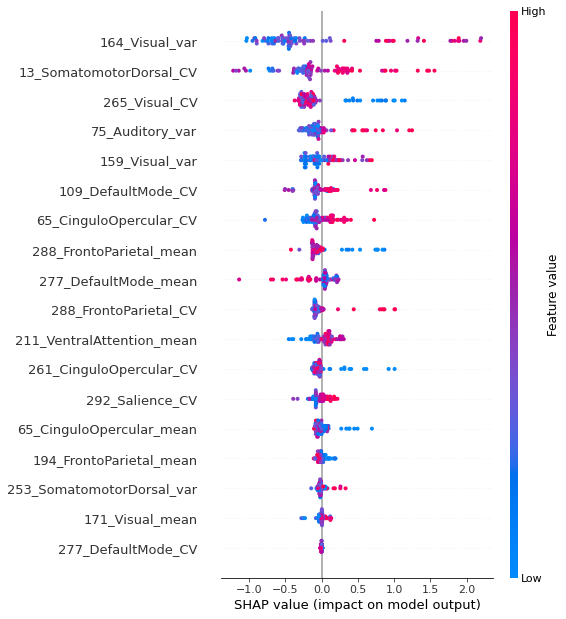

In [103]:
#XGB Shap (ALFF_AD8)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,7])
shap.summary_plot(shap_values,patient_data_dropX)

In [89]:
# get shap Values(ALFF_AD8)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data_dropX.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(mvc)/{}_{}_AD8(mvc).csv'.format(data_value_type,data_type))

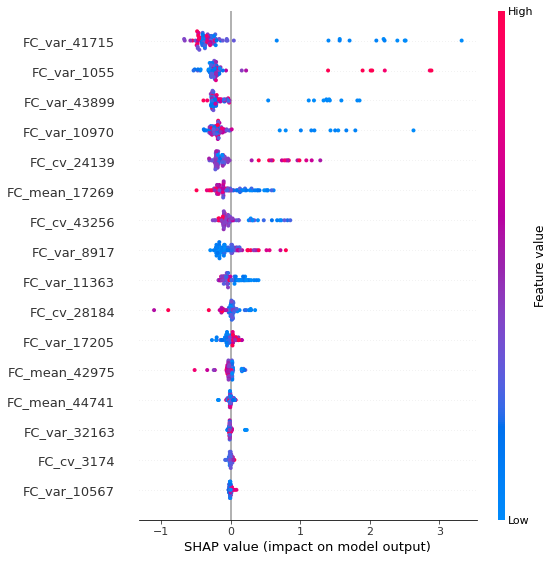

In [97]:
#XGB Shap (FC_AD8)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,7])
shap.summary_plot(shap_values,patient_data)

In [98]:
# get shap Values(FC_AD8)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(mvc)/{}_{}_AD8(mvc).csv'.format(data_value_type,data_type))

# no cv data shap

In [ ]:
#XGB Shap (ALFF_AD8)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,7])
shap.summary_plot(shap_values,patient_data)

In [ ]:
# get shap Values(ALFF_AD8)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(Final)/{}_{}_AD8.csv'.format(data_value_type,data_type))

In [ ]:
#XGB Shap (FC_AD8)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,7])
shap.summary_plot(shap_values,patient_data)

In [30]:
# get shap Values(FC_AD8)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(Final)/{}_{}_AD8.csv'.format(data_value_type,data_type))

# MOCA

In [34]:
#MOCA

result_dict={'outcome':[], 'model':[], 'Reg:mae':[], 'Reg:mse':[],  'Reg:mape':[] }
grid_stack, scores_stack = [], []
outcome_name = 'MOCA客觀認知測驗分數[<=23,>=24]'

model_XGB = XGBRegressor()
model_LGBM = LGBMRegressor()
model_MLPR  = MLPRegressor()

label_ = clinical_data[outcome_name]                    # AD8 and MOCA data (each 84)
label_ = label_+1
index,patient_data,patient_value = loader_(data_path = [raw_data_path, next_path], outcome_name = outcome_name)

print(index)
print("Overall: ",patient_value.shape)
print("Feature Number: {}".format(patient_value.shape[1]))

# if data_value_type =='FC':
#     print("FC Outcome: {}[{}] - cut rank point: {} - GridSearch: {}".format(outcome_name, data_type, rank_threshold, grid))
# else:
#     print("ALFF Outcome: {}[{}] - cut rank point: {} - GridSearch: {}".format(outcome_name, data_type, rank_threshold, grid))

patient_data.to_csv('./MOCA/{}_{}_MOCA(new).csv'.format(data_value_type,data_type))

print()
print("-------Start Training model -------")
print()

if cross_v==True:

    model_XGB = model_XGB.fit(patient_value, np.array(label_))
    overall_pred =  model_XGB.predict(patient_value)
    
    model_LGBM = model_LGBM.fit(patient_value, np.array(label_))
    overall_pred =  model_LGBM.predict(patient_value)

    model_MLPR = model_MLPR.fit(patient_value, np.array(label_))
    overall_pred =  model_MLPR.predict(patient_value)

print('------------------Done------------------')

['FC_cv_2764', 'FC_mean_3611', 'FC_var_25328', 'FC_cv_25468', 'FC_mean_10268', 'FC_mean_9328', 'FC_mean_38646', 'FC_var_11977', 'FC_var_43637', 'FC_cv_6569', 'FC_var_23239', 'FC_mean_37593', 'FC_var_13227', 'FC_var_20137', 'FC_mean_8021']
Overall:  (84, 15)
Feature Number: 15

-------Start Training model -------

------------------Done------------------


# patient data(original)_FC

In [35]:
patient_data

,FC_cv_2764,FC_mean_3611,FC_var_25328,FC_cv_25468,FC_mean_10268,FC_mean_9328,FC_mean_38646,FC_var_11977,FC_var_43637,FC_cv_6569,FC_var_23239,FC_mean_37593,FC_var_13227,FC_var_20137,FC_mean_8021
0,1.147391,-0.12305,0.019060,2.345911,0.2281,0.05807,0.16490,0.01630,0.05362,1.004071,0.03967,0.2690,0.05180,0.04535,0.46730
1,0.993808,0.00790,0.062870,-2.776903,0.3481,0.28800,0.00184,0.01930,0.03833,-2.264507,0.03485,0.4138,0.03168,0.06586,0.38130
2,-3.341395,0.30860,0.055700,-0.807032,0.5410,0.43400,0.54600,0.04960,0.02808,0.790959,0.00981,0.7144,0.03967,0.01898,0.94240
3,1.465210,0.52900,0.040220,1.958808,0.2837,0.12460,0.63300,0.03375,0.01643,0.647034,0.04970,0.7700,0.00546,0.02567,0.60940
4,8.678306,0.05660,0.023470,-0.462419,0.2673,0.22420,0.35800,0.02927,0.03345,-2.023706,0.04764,0.2472,0.01469,0.03300,0.58800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.583071,0.07530,0.009160,0.502348,0.1036,0.18710,0.46780,0.04280,0.01006,2.493564,0.03635,0.6880,0.06550,0.04227,0.38800
80,0.485092,-0.04715,0.050380,-15.401432,0.5923,0.43000,-0.02065,0.02920,0.09750,0.988961,0.02348,0.3533,0.04623,0.04022,0.18090
81,1.562047,0.35080,0.051820,-1.271579,0.3882,0.22300,0.18970,0.02744,0.03700,6.391138,0.00812,0.5300,0.05490,0.03574,-0.01547
82,-11.341390,0.24460,0.019640,1.017840,0.4530,0.08105,0.25460,0.01135,0.02776,1.784809,0.14560,0.3274,0.06305,0.14320,0.27930


In [16]:
patient_data.to_csv('./Cluster(original_data)/R_feature_selection(mvc)/{}_{}_MOCA.csv'.format(data_value_type,data_type),index=False)

# ALFF cv data columns only

In [21]:
# cv data only

new_index = []

for i in range(0,len(patient_data.columns)):
    list_patient = list(patient_data.columns[i])
    list_patient.pop(0)
    new_index .append(''.join(list_patient))

patient_data_dropX = pd.DataFrame(patient_data.values,columns= new_index)

In [22]:
patient_data_dropX

,53_CinguloOpercular_var,226_DorsalAttention_mean,153_Visual_CV,244_Reward_mean,244_Reward_CV,53_CinguloOpercular_mean,86_DefaultMode_mean,236_MedialTemporalLobe_var,220_DorsalAttention_CV,67_CinguloOpercular_CV
0,0.135703,0.720163,0.325585,1.351738,0.360542,0.946753,1.069814,0.177912,0.413757,0.340317
1,0.071791,0.815558,0.368465,1.337606,0.347153,0.614881,1.269004,0.148180,0.351228,0.394583
2,0.120411,0.654750,0.275269,0.977734,0.379647,0.934557,0.901096,0.145636,0.373839,0.406300
3,0.115992,0.789180,0.389144,1.607163,0.298571,0.710695,1.448579,0.138414,0.313322,0.342229
4,0.115215,0.779071,0.309826,1.249732,0.354411,0.760041,0.887622,0.162129,0.309422,0.339170
...,...,...,...,...,...,...,...,...,...,...
79,0.122729,0.715122,0.374075,1.429644,0.316561,0.805111,0.776462,0.177958,0.392011,0.356703
80,0.184261,0.637073,0.240485,1.229561,0.342852,1.119377,0.883707,0.102132,0.399926,0.490255
81,0.164143,0.861345,0.277092,1.396898,0.328292,1.416257,0.821132,0.127920,0.359523,0.311572
82,0.218356,0.607621,0.255396,1.236753,0.331107,1.448193,1.004591,0.169149,0.386509,0.319198


In [24]:
patient_data_dropX.to_csv('./Cluster(original_data)/R_feature_selection(mvc)/{}_{}_MOCA.csv'.format(data_value_type,data_type),index=False)

# shap

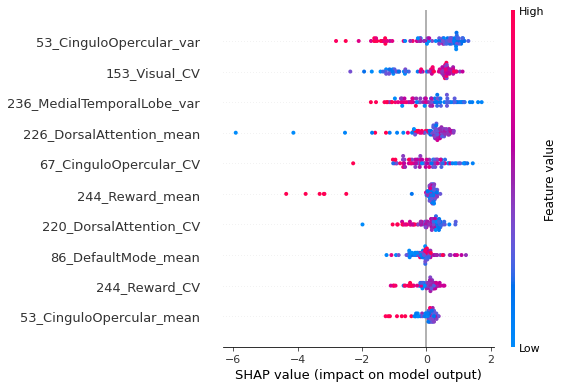

In [109]:
#XGB Shap(ALFF_MOCA)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,9])
shap.summary_plot(shap_values,patient_data_dropX)

In [110]:
# get shap Values(ALFF_MOCA)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(mvc)/{}_{}_MOCA.csv'.format(data_value_type,data_type))

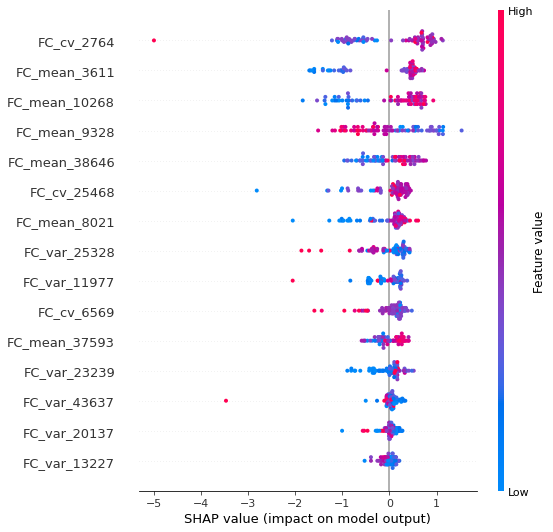

In [114]:
#XGB Shap(FC_MOCA)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,9])
shap.summary_plot(shap_values,patient_data)

In [115]:
# get shap Values(FC_MOCA)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(mvc)/{}_{}_MOCA.csv'.format(data_value_type,data_type))

# no cv data shap

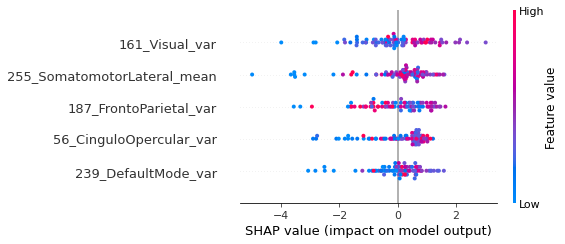

In [35]:
#XGB Shap(ALFF_MOCA)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,9])
shap.summary_plot(shap_values,patient_data)

In [36]:
# get shap Values(ALFF_MOCA)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(Final)/{}_{}_MOCA.csv'.format(data_value_type,data_type))

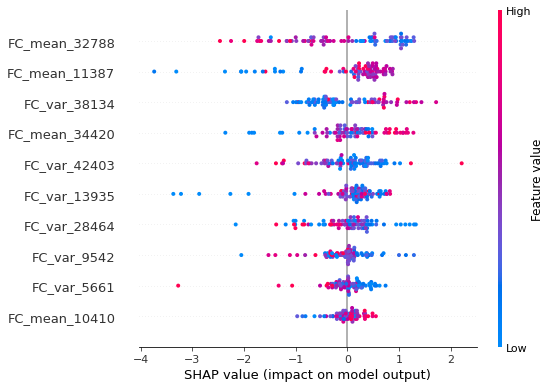

In [5]:
#XGB Shap(FC_MOCA)

explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(patient_value)
# shap.summary_plot(shap_values,patient_data,plot_size=[16,9])
shap.summary_plot(shap_values,patient_data)

In [6]:
# get shap Values(FC_MOCA)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(patient_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

sort_feature = feature_importance['col_name'].tolist()
sortedShap_csv= pd.DataFrame(shap_values,columns=sort_feature)
sortedShap_csv.to_csv('./Cluster(ShapValues)/XGB/XGB(Final)/{}_{}_MOCA.csv'.format(data_value_type,data_type))